# MA6202: Laboratorio de Ciencia de Datos

**Profesor: Nicolás Caro**\
**Auxiliar: Rodrigo Lara M**

**17/05/2020 - Tarea 1**


**Integrantes del grupo**: Pablo Araya Z., Fabian Badilla M.

## 1 Introducción
La siguiente evaluación corresponde a la primera tarea del curso de laboratorio de ciencia de datos. A modo de contexto, se trabajará con un conjunto de datos, en el cual se busca una estimación del precio por metro cuadrado para viviendas en la ciudad de Bogotá, se busca además de una estimación de incertidumbre en predicción.\
Para ello, se proporcionan datos recolectados por _web-scrapping_ y una serie de estadísticas que caracterizan determinadas zonas geográficas de interés, llamadas Unidades de Planeación Zonal (UPZ).

Las condiciones de entrega requeridas son:

* La extensión máxima de el informe es de 6 planas a las que puede añadir 2 para demostraciones.
* Debe adjuntar un repositorio `git` donde se incluya todo su código.
* A lo menos 1 `commit` por cada pregunta de la tarea
* Por lo menos 1 `merge` a través de su trabajo.
* Incluya un documento `jupyter notebook` llamado `tarea1.ipynb` en el cual se exponga todo el procedimiento realizado.
* Por último es necesario también entregar un archivo _pickle_ denominado `modelo.pk` que contenga el último modelo de regresión entrenado.

Tenga en mente que su informe será revisado por un equipo técnico que debe entender a cabalidad su metodología, ser capaz de replicarlo y evaluarlo a partir de la lectura de este.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.base import RegressorMixin, BaseEstimator
import missingno as msno

warnings.filterwarnings('ignore')

## P1. Carga y limpieza de datos
En la presente sección se realizan los pasos de carga y limpieza de datos que permitirán realizar las secciones
posteriores con un `DataFrame` consolidado que presente los tipos de datos adecuados para la información contenida
en sus columnas.\
Incluya en el reporte todas las decisiones que llevó en esta seccion, ademas de reportar y discutir acerca de
los aspectos específicos señalados en cada pregunta.

1. Los datos recolectados en la carpeta `data/raw` están divididos en carpetas con el formato `wNN` donde `NN` corresponde a la semana del año en la que estos fueron consultados. Cargue los datos en un solo `DataFrame` y elimine las filas duplicadas. Además genere una variable categórica en la que se indique si la observación correspondiente proviene de un archivo que en su nombre contiene `'furnished'`\
(ejemplo: metrocuadrado_furnished_wNN.csv).\
**Hint:** para lo último puede ser útil estudiar los argumentos del
método `pd.merge`. Reporte si existen observaciones de archivos con texto `'furnished'` que no estén contenidos en archivos con texto `'all'`.

In [2]:
''' Se juntan los dfs de los csv con nombre "all" '''
df_s = []
for i in range(13,18):
    w = "w"+str(i)
    direccion = 'data/raw/'+w+'/metrocuadrado_all_'+w+'.csv'
    df = pd.read_csv(direccion)
    df_s.append(df)
df_all = pd.concat(df_s,axis=0,ignore_index = True)

'''Creamos la variable categorica'''
df_all['Archivo'] = 'all'

''' Eliminamos los datos duplicados'''
df_all.drop_duplicates(inplace=True,ignore_index=True)

''' Se juntan los dfs de los csv con nombre "furnished" '''
df_s = []
for i in range(13,18):
    w = "w"+str(i)
    direccion = 'data/raw/'+w+'/metrocuadrado_furnished_'+w+'.csv'
    df = pd.read_csv(direccion)
    df_s.append(df)
df_fur = pd.concat(df_s,axis=0,ignore_index = True)

'''Creamos la variable categorica'''
df_fur['Archivo'] = 'furnished'

''' Eliminamos los datos duplicados'''
df_fur.drop_duplicates(inplace=True,ignore_index=True)

''' Juntamos los dos dfs'''
df = pd.concat([df_all,df_fur],axis=0,ignore_index = True)

''' Eliminamos posibles datos de furnished que esten en all'''
df.drop_duplicates(['property_type|rent_type|location', 'price', 'n_rooms', 'n_bath','surface', 'details',
                    'url', 'metrocuadrado_index'],inplace=True,ignore_index=True)

print('Hay',sum(df['Archivo']=='furnished'),'Observaciones de furnished que no estan contenidas en all')

Hay 2099 Observaciones de furnished que no estan contenidas en all


2. Limpie las columnas:
    1. Precio y de área del inmueble, número de habitaciones y número de baños.
    2. De `'property type|rent type|location'`. Debe obtener 3 columnas en las que se detalle el tipo de inmueble (casa o apartamento), el tipo de la oferta (arriendo o arriendo y venta) además de el barrio en el cual se ubica el inmueble (texto en mayúsculas para la mayoría de los casos) Llame a esta última columna `'location'`.\
    __Hint:__ Para ello pueden ser útiles los métodos `str.split` y `str.strip` de la clase `pd.Series`.

In [3]:
''' Quitamos los nan '''
df = df.dropna(axis = 0)#,subset=['price','n_rooms','n_bath','surface'])
df.reset_index(drop=True,inplace=True)

''' Limpiamos los datos de price y surface '''
df['price'] = [x.replace('$','') for x in df['price']]
df['price'] = [x.replace('.','') for x in df['price']]
df['price'] = df['price'].astype('float64')
df['surface'] = [x.replace(' m2','') for x in df['surface']]
df['surface'] = df['surface'].astype('float64')

''' Cambiar el formato de los datos n_bath y n_rooms'''
for i in range(len(df['n_bath'])):
    if type(df['n_bath'][i]) == float:
        df['n_bath'][i] = str(int(df['n_bath'][i]))
        
for i in range(len(df['n_rooms'])):
    if type(df['n_rooms'][i]) == float:
        df['n_rooms'][i] = str(int(df['n_rooms'][i]))

df.dtypes

property_type|rent_type|location     object
price                               float64
n_rooms                              object
n_bath                               object
surface                             float64
details                              object
url                                  object
metrocuadrado_index                 float64
Archivo                              object
dtype: object

In [4]:
''' Separar la primera columna en las 3 columnas respectivas'''

columna = 'property_type|rent_type|location'
first_col = df[columna]
first_col = pd.Series([x.replace(' ',',', 1) for x in first_col])
first_col = first_col.str.split(pat=',',expand =True)
first_col.columns = columna.split('|')
first_col['rent_type'] =  [x.replace('en ','') for x in first_col['rent_type']]
df = pd.concat([first_col,df.iloc[:,1:]],axis=1)
df['location'] = [x.replace(' ','', 1) for x in df['location']]

3. Adjunte las siguientes columnas:
    1. Genere una variable que represente el precio por metro cuadrado.
    2. Obtenga el número de garajes procesando la columna `'url'` .

In [5]:
''' Se genera la nueva columna del precio por metro cuadrado'''
df['Precio_m2'] = df['price']/df['surface']

In [6]:
''' Generar la columna del numero de garajes'''
num_gar = []
for x in df['url']:
    if '-garajes' not in x:
        num_gar.append('0')
    else:
        num_gar.append(x[x.find('banos-')+6:x.find('-garajes')])
df['Numero_Garajes'] = num_gar

4. Clasifique las observaciones por tipo de producto de acuerdo a los criterios de la Tabla
    1. Hint: puede ser útil el método `query` de `pd.DataFrame`

|Tipo de Producto| Tipo de Inmueble| área min | área max |
|----------------|-----------------|----------|----------|
|        1       |       casa      | 80       |    <120  |
|        2       |       casa      | 120      |    <180  |
|        3       |       casa      | 180      |    <240  |
|        4       |       casa      | 240      |    <360  |
|        5       |       casa      | 360      |    460   |
|        6       |   apartamento   | 40       |    <60   |
|        7       |   apartamento   | 60       |    <80   |
|        8       |   apartamento   | 80       |    120   |

In [7]:
''' Generar el tipo de producto segun la condicion'''

condiciones = ['80<=surface<120 and property_type=="Casa"','120<=surface<180 and property_type=="Casa"',
              '180<=surface<240 and property_type=="Casa"','240<=surface<360 and property_type=="Casa"',
              '360<=surface<=460 and property_type=="Casa"','40<=surface<60 and property_type=="Apartamento"',
              '60<=surface<80 and property_type=="Apartamento"','80<=surface<=120 and property_type=="Apartamento"']
df['tipo_producto'] = np.zeros(len(df))
for i in range(1,9):
    ind = df.query(condiciones[i-1]).index
    df.loc[ind,'tipo_producto']=i

5. A partir de la columna `'barrio'`, haga una fusión con el archivo `data/assignacion upz/barrio-upz-asignacion.csv` para obtener así el código de la UPZ de cada inmueble. Reporte el numero de observaciones y de barrios a los que no se les puede adjuntar un código UPZ a partir de este archivo. Tenga en cuenta que aproximadamente 90% de los datos tiene información sobre UPZ.

In [8]:
'''Cargamos los datos'''
barrio_upz =pd.read_csv('data/asignacion_upz/barrio-upz.csv')
barrio_upz.drop(['UPlTipo','UPlNombre'], axis=1, inplace=True)

''' Para realizar lo anterior hay que limpiar la columna location'''
df['location'] =  [x.replace(' Bogotá D.C..','') for x in df['location']]
df['location'] =df['location'].str.lower()

''' Cambiamos el nombre de la columna para poder juntar los df '''
barrio_upz.rename(columns={"pro_location": "location"},inplace = True)

'''Juntamos los data frames'''
df = pd.merge(df,barrio_upz,how ='left',on ='location')

''' Reporte de a cuantos barrios no les pudo asignar codigo'''
num_nan = df['UPlCodigo'].isna().sum()
por_nan = 100-df['UPlCodigo'].isna().sum()*100/len(df)
print('N° Observaciones sin codigo:',num_nan)
print('% Observacions sin codigo:',por_nan.round(3))

N° Observaciones sin codigo: 1974
% Observacions sin codigo: 89.077


6. En la carpeta `data/estadisticas_upz` encontraría todos los archivos que debe fusionar con su `DataFrame`, a través del código de UPZ, para así enriquecer su conjunto de datos con estadísticas de población, socioeconómicas y de calidad de vida a nivel de UPZ. Una vez realizada la fusión, adjunte una nueva columna con la densidad de población por UPZ.

In [9]:
''' Cargamos los 3 csv'''
esta = pd.read_csv('data/estadisticas_upz/estadisticas_poblacion.csv',index_col = 0)
ind = pd.read_csv('data/estadisticas_upz/indice_inseguridad.csv',index_col = 0)
porct = pd.read_csv('data/estadisticas_upz/porcentaje_areas_verdes.csv',index_col = 0)

''' Cambiamos los datos para poder hacer el merge'''
esta.rename(columns={"upz": "UPlCodigo"},inplace = True)
porct.rename(columns={"cod_upz": "UPlCodigo"},inplace = True)
porct['UPlCodigo']= porct['UPlCodigo'].apply(int)
porct['UPlCodigo'] = ['UPZ'+str(x) for x in porct['UPlCodigo']]

''' Juntamos los dfs '''
df = pd.merge(df,esta,how ='left',on ='UPlCodigo')
df = pd.merge(df,ind,how ='left',on ='UPlCodigo')
df = pd.merge(df,porct,how ='left',on ='UPlCodigo')

In [10]:
''' Generar la densidad poblacional por UPZ'''
df['Density'] = df['personas']/df['UPlArea']

In [11]:
'''Se borran columnas repetidas o que no aportan info util'''
df.drop(['nomupz','UPlNombre2','url','details'], axis=1, inplace=True)
df.rename(columns={"upz": "UPlNombre"},inplace = True)
df.to_pickle('./data/data.pkl')

## P2. EDA
En la siguiente pregunta utilice el `DataFrame` obtenido a partir de los procedimientos anteriores. La idea central del presente ejercicio es analizar la base de datos que fue construida realizando un análisis exploratorio de datos (EDA) riguroso que permite obtener información útil para la parte final de tarea. Para cada pregunta y considerando que la variable de respuesta es el precio por metro cuadrado, discuta sus resultados y reporte algunos gráficos interesantes en su informe.

1. Programe una función `estilo()` que aplica un estilo de gráficos por defecto diseñado por usted. Este estilo debe ser empleado en todos los gráficos que incluya en su informe.\
__Hint:__ Use métodos de la librería `seaborn` para ello.

In [12]:
def estilo():
    miestilo= { 'axes.edgecolor': 'black',
                'axes.axisbelow': True,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'patch.edgecolor':'none',
                'patch.force_edgecolor': False,
                'axes.spines.right': False,
                'axes.spines.top': False, 
                }
    sns.set(style='darkgrid', rc=miestilo)
    
estilo()

2. Perfile las variables obtenidas en su `DataFrame`, agrúpelas y analícelas según su naturaleza. En función de su agrupación, grafíque las distribuciones dando un tratamiento adecuado a cada tipo de variable, discuta ciertos casos de interés.

In [12]:
'''Se carga el dataset limpiado'''
df=pd.read_pickle('./data/data.pkl')

'''
Se separan las columnas en variables numericas y categoricas. Se formatean como float64 y str respectivamente:
'''
numeric = ['price', 'surface', 'metrocuadrado_index', 
       'Precio_m2',  'UPlArea','personas','trabajoinf_ninos_5_17_anos_perc',
       'trabajoinfampliado_ninos_5_17_anos_perc', 'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
       'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad', 'areas_verdes_perc', 'Density']
categorical = list(set(df.columns) - set(numeric))
numeric.sort()
categorical.sort()

df = df.astype({col:'str' for col in categorical})
df = df.astype({col:'float64' for col in numeric})

mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])

df = df.reindex(columns=numeric + categorical)
df.columns = pd.MultiIndex.from_tuples(mapping)


'''No considero outliers de algunas columnas (solucion por ahora)'''
for col in ['Precio_m2','surface']:
    q = df.numeric[col].quantile(0.98)
    df=df[df.numeric[col] < q]

### Variables Categoricas

In [13]:
len(categorical)

10

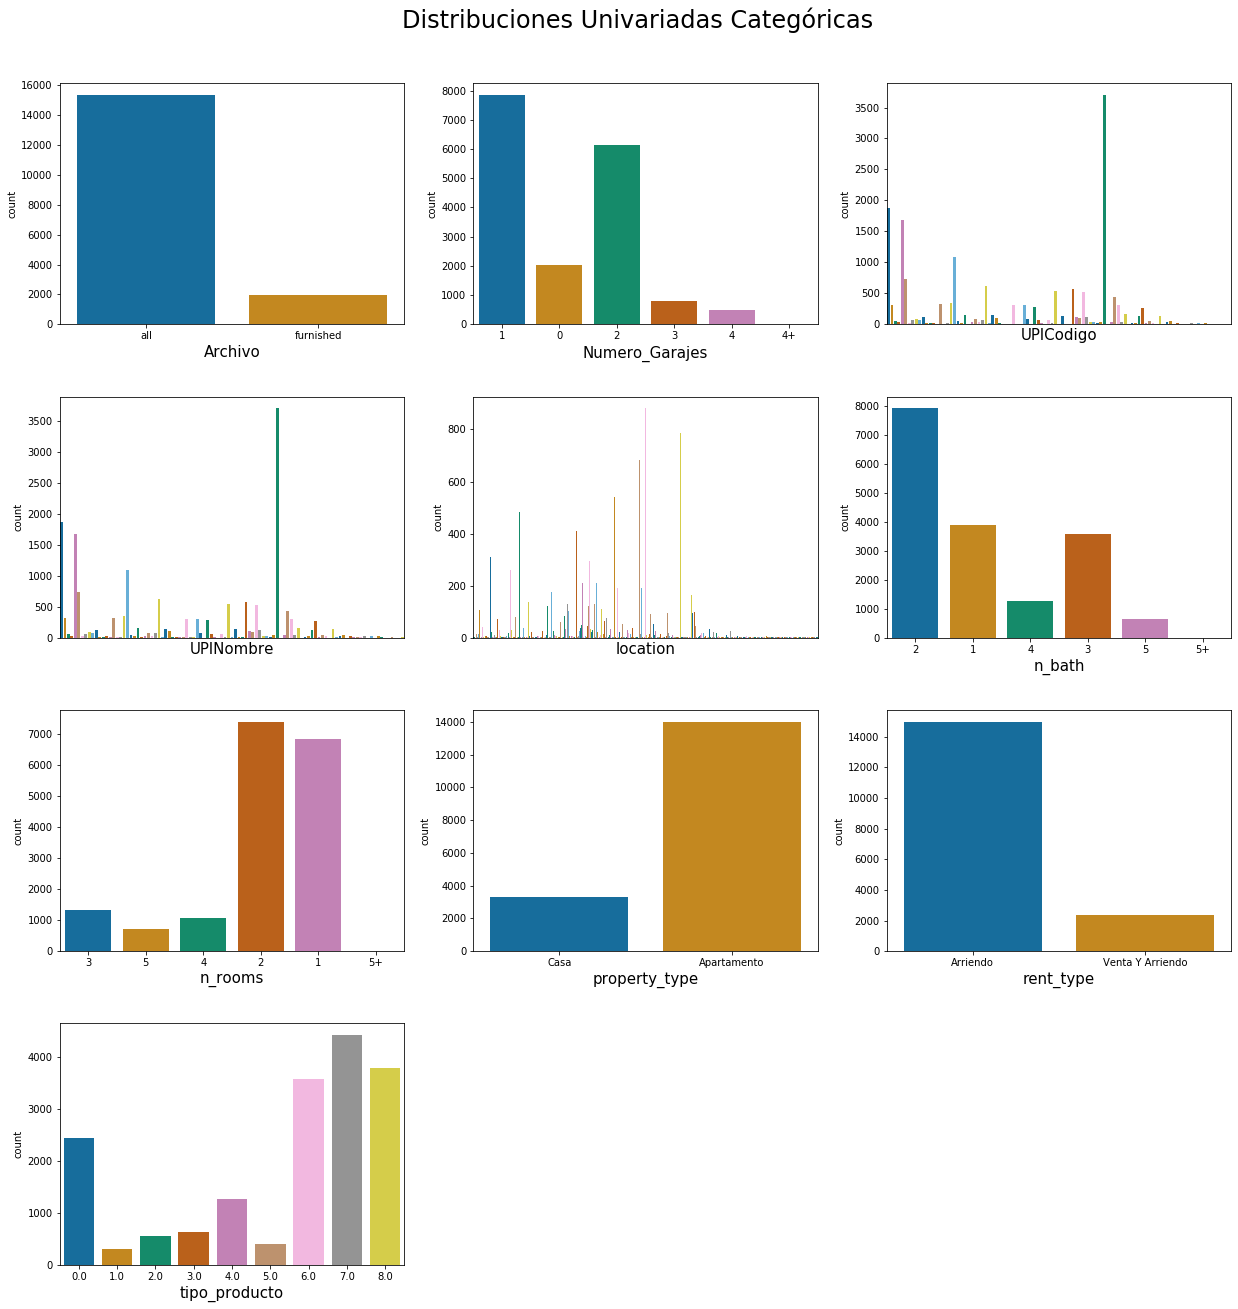

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=[17, 17] )
list(map(lambda a : a.remove(), ax[-1,-2:]))

fig.tight_layout()
fig.suptitle('Distribuciones Univariadas Categóricas',fontsize=24,x=0.5,y=1.05)

for axis, col in zip(ax.flatten(), categorical):
    # Graficos para datos tipos str
    sns.countplot(df[('categorical',col)], ax=axis, palette='colorblind')
    axis.set_xlabel(col, fontsize=15)
    if col in ['UPlCodigo','UPlNombre','location']:
        axis.get_xaxis().set_ticks([])
h, w = (.3, .2)
plt.subplots_adjust(wspace=w, hspace=h)
fig.savefig('./fig/categorical.pdf', bbox_inches='tight')

## Interesantes (?)

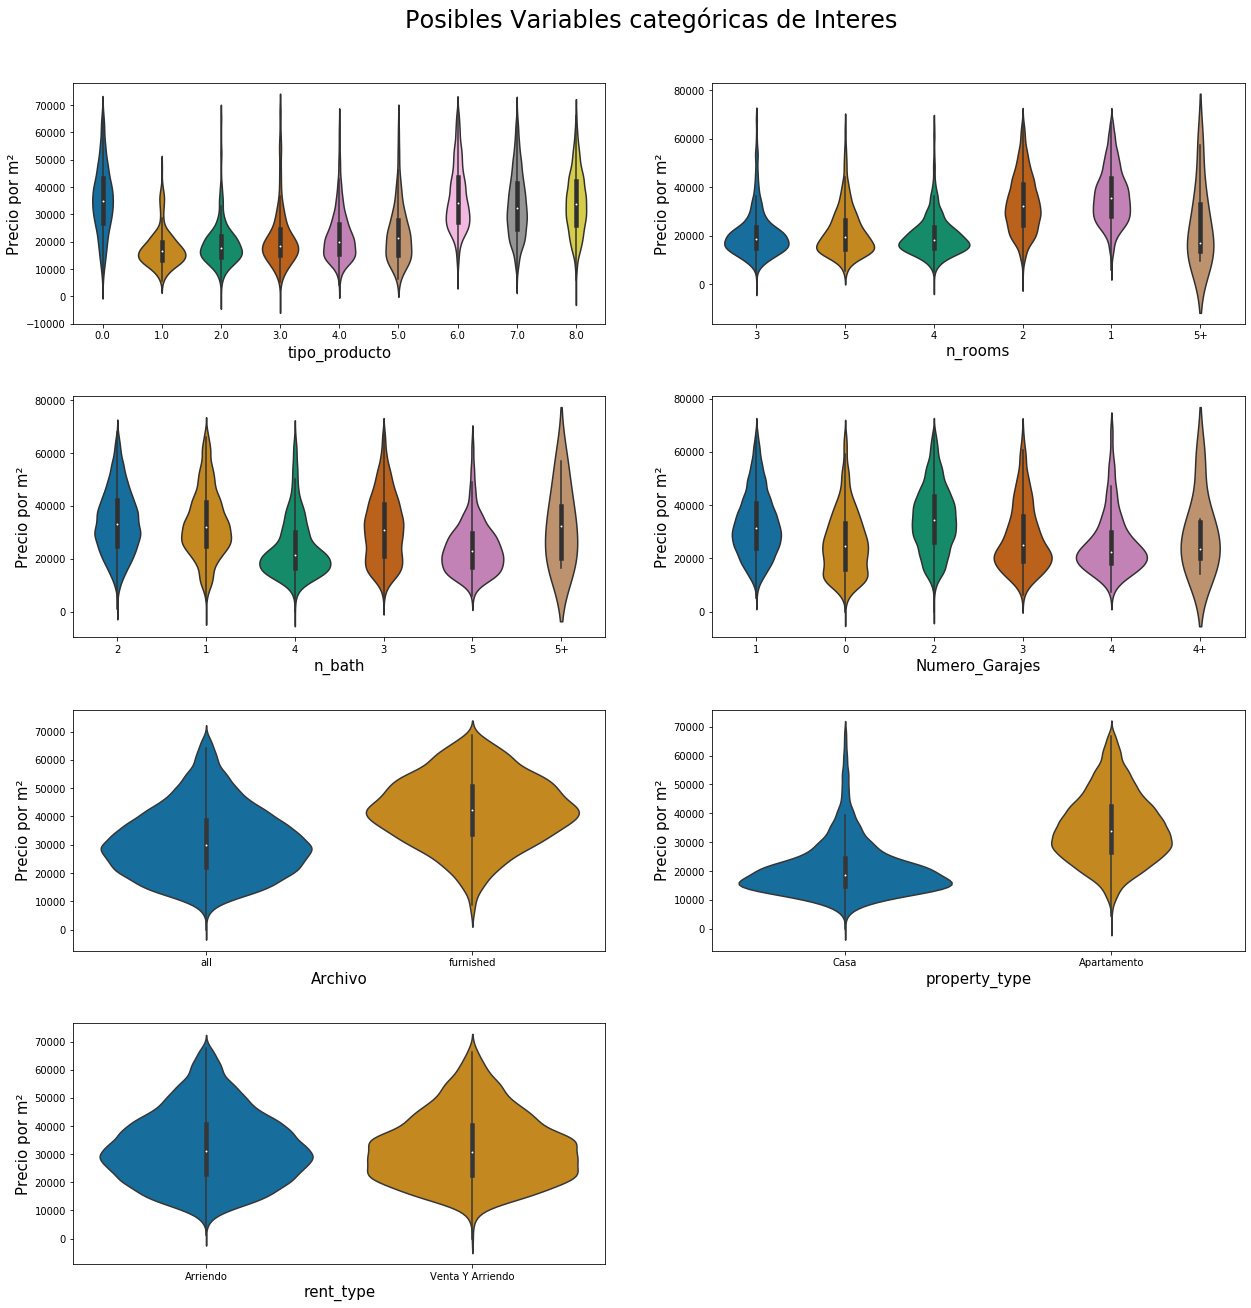

In [15]:
interes= ['tipo_producto','n_rooms','n_bath', 'Numero_Garajes','Archivo', 'property_type','rent_type']

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[17, 17] )
list(map(lambda a : a.remove(), ax[-1,-1:]))

fig.tight_layout()
fig.suptitle('Posibles Variables categóricas de Interes',fontsize=24,x=0.5,y=1.05)

for axis, col in zip(ax.flatten(), interes):
    # Graficos para datos tipos str
    sns.violinplot(x=('categorical',col),y=('numeric','Precio_m2'),data=df,kind='violin',ax=axis, palette='colorblind')
    axis.set_xlabel(col, fontsize=15)
    axis.set_ylabel('Precio por m²', fontsize=15)
h, w = (.3, .2)
plt.subplots_adjust(wspace=w, hspace=h)
fig.savefig('./fig/cat_interes.pdf', bbox_inches='tight')

In [ ]:
#Todas se ven interesantes de analizar salvo rent_type.
#Es curioso que los lugares con muchos baños, piezas o garages bajen el precio por m_2 (lugares muy grandes?)

### VariablesNumericas

In [16]:
len(numeric)

15

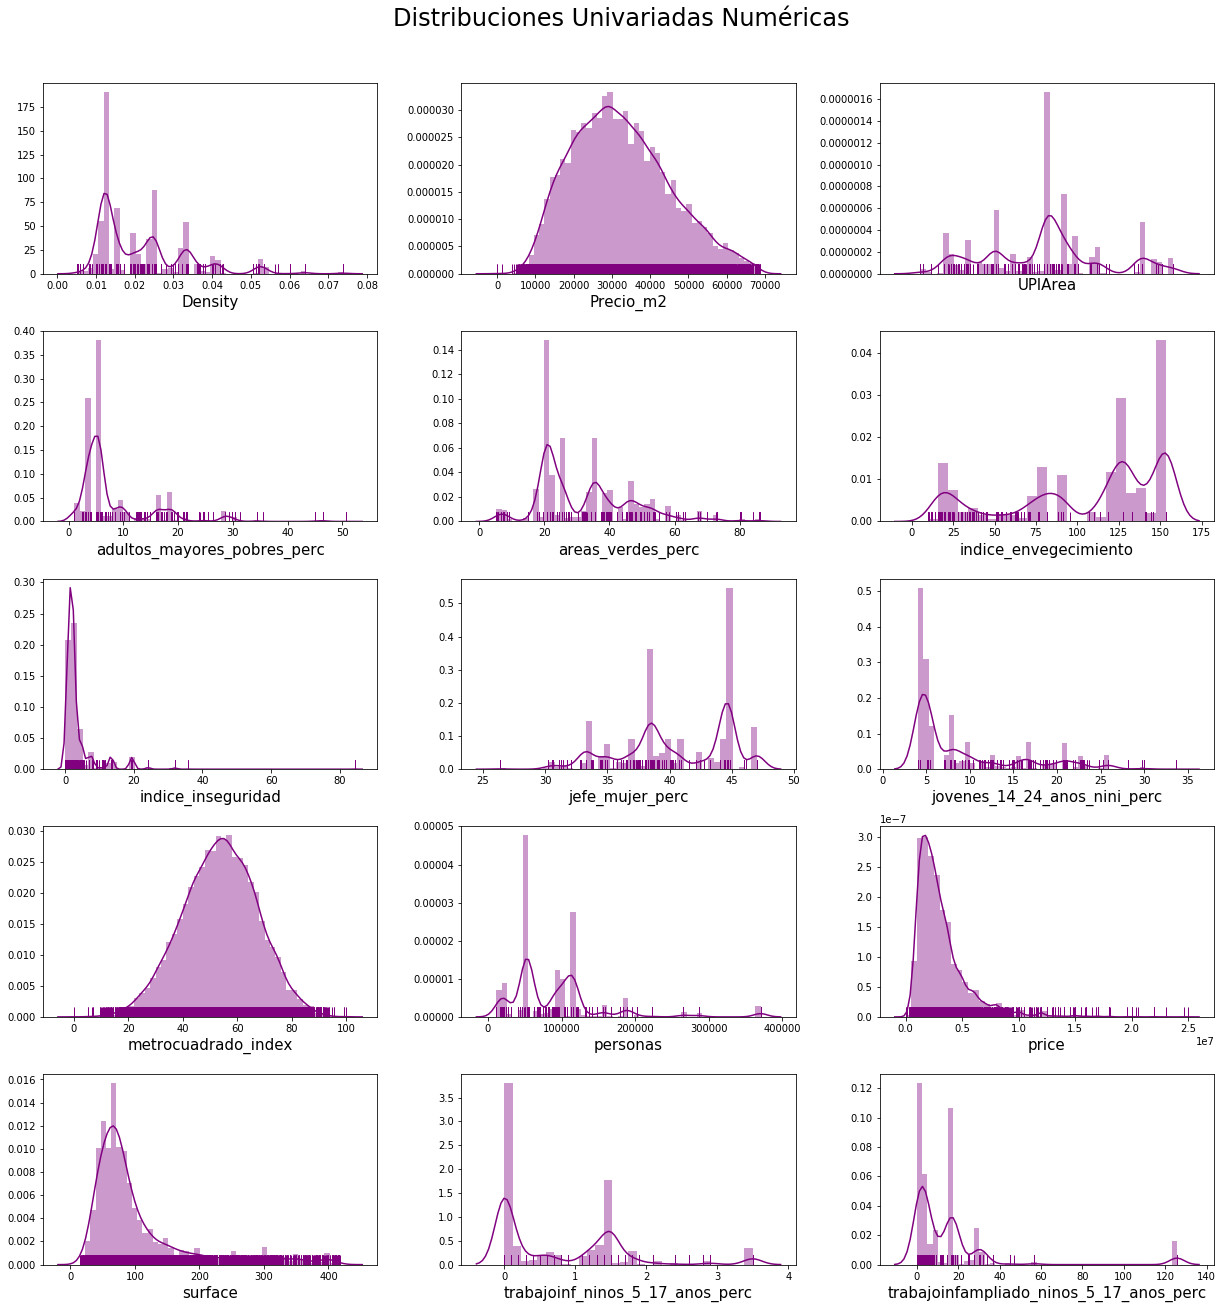

In [17]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=[17, 17])
fig.tight_layout()

fig.suptitle('Distribuciones Univariadas Numéricas',fontsize=24,x=0.5,y=1.05)

for axis, col in zip(ax.flatten(), numeric):
    # Graficos para datos numericos
    sns.distplot(df[('numeric', col)], ax=axis, rug=True, color='purple')
    axis.set_xlabel(col, fontsize=15)
    if col in ['UPlArea']:
        axis.get_xaxis().set_ticks([])

w, h = (.25, .3)
plt.subplots_adjust(wspace=w, hspace=h)
fig.savefig('./fig/numeric.pdf', bbox_inches='tight')

## Interesantes(?)

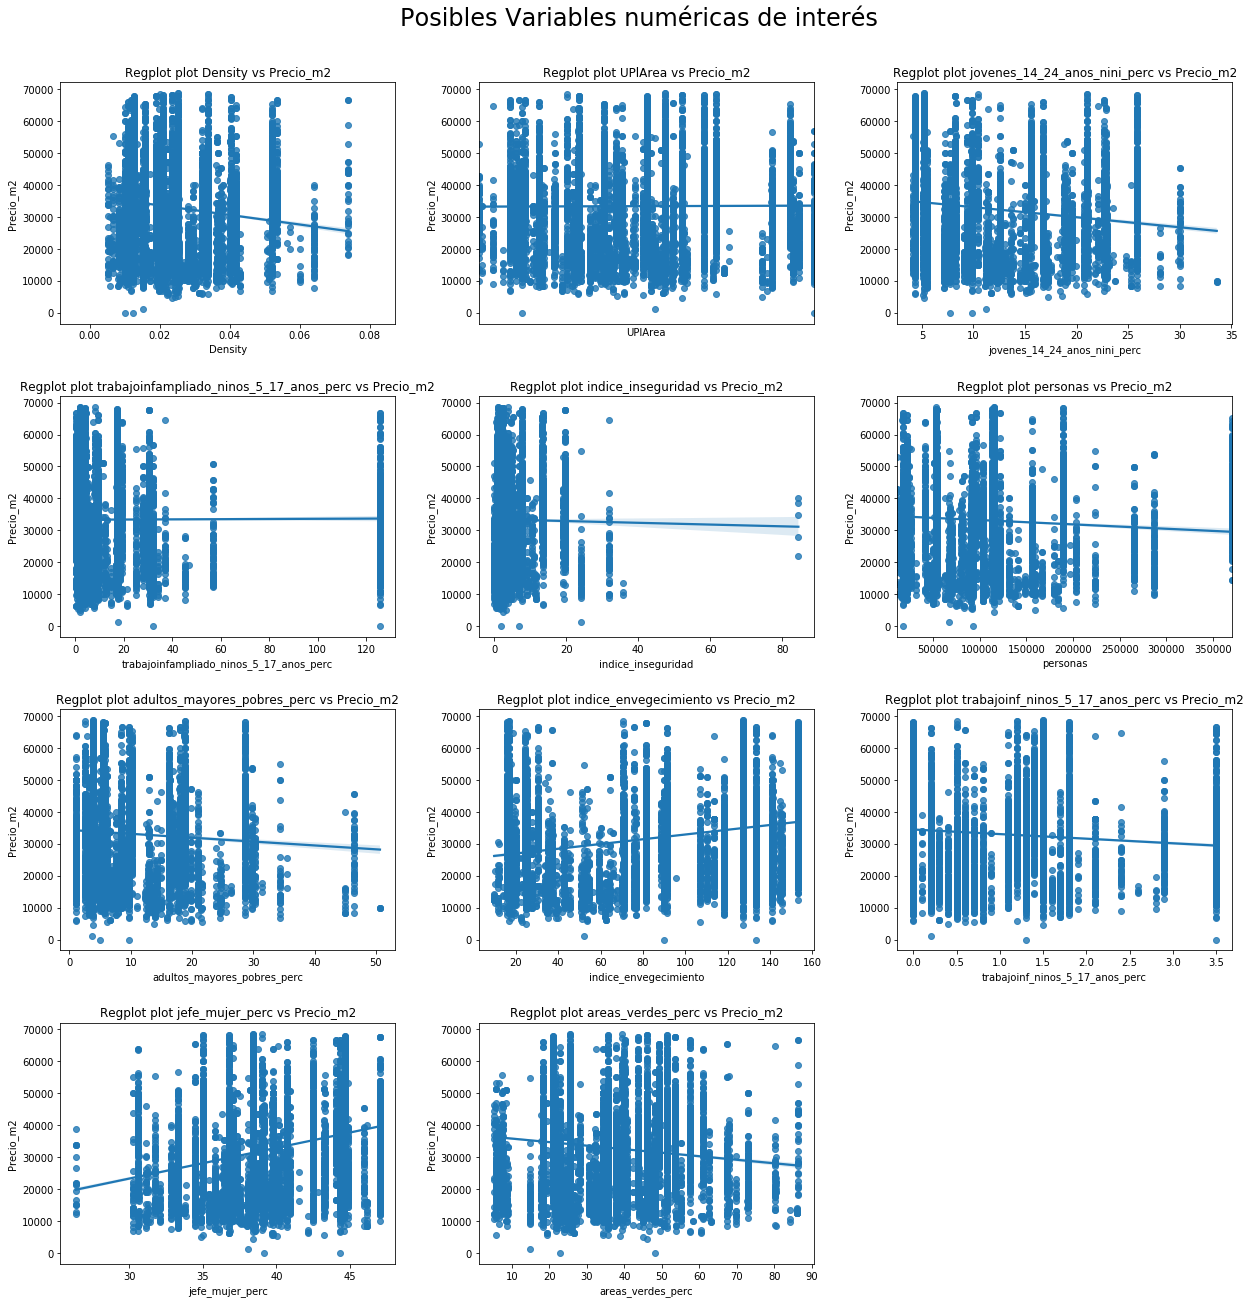

In [18]:
interes= list(set(numeric)-set(['price','surface','metrocuadrado_index', 'Precio_m2']))

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(17,17))
list(map(lambda a : a.remove(), ax[-1,-1:]))
fig.tight_layout()

fig.suptitle('Posibles Variables numéricas de interés',fontsize=24,x=0.5,y=1.05)


for axis, col in zip(ax.flatten(), interes):
    sns.regplot(x=df[('numeric', col)],y=df[('numeric', 'Precio_m2')],ax=axis)
    axis.set_title('Regplot plot {} vs Precio_m2'.format(col))
    axis.set_xlabel(col)
    axis.set_ylabel('Precio_m2')
    if col in ['UPlArea']:
        axis.get_xaxis().set_ticks([])
        
w, h = (.25, .3)
plt.subplots_adjust(wspace=w, hspace=h)
fig.savefig('./fig/num_interes.pdf', bbox_inches='tight')

In [ ]:
#Esta rara esta parte, no se si nos sirva

3. Estudie la presencia de datos faltantes en la base de datos. Observe como se distribuyen estos y establezca un mecanismo de pérdida de información basándose en los patrones observables del conjunto de datos. Busque agrupaciones de columnas que muestren un comportamiento sistemático y plantee sus reflexiones.\
Respalde con visualizaciones y cuantifique estadísticamente los patrones observados.

In [19]:
import missingno as msno

In [20]:
df.replace('nan',np.nan, inplace = True)
df.isnull().sum()

numeric      Density                                    1872
             Precio_m2                                     0
             UPlArea                                    1872
             adultos_mayores_pobres_perc                1872
             areas_verdes_perc                          1872
             indice_envegecimiento                      1872
             indice_inseguridad                         1872
             jefe_mujer_perc                            1872
             jovenes_14_24_anos_nini_perc               1872
             metrocuadrado_index                           0
             personas                                   1872
             price                                         0
             surface                                       0
             trabajoinf_ninos_5_17_anos_perc            1872
             trabajoinfampliado_ninos_5_17_anos_perc    1872
categorical  Archivo                                       0
             Numero_Gara

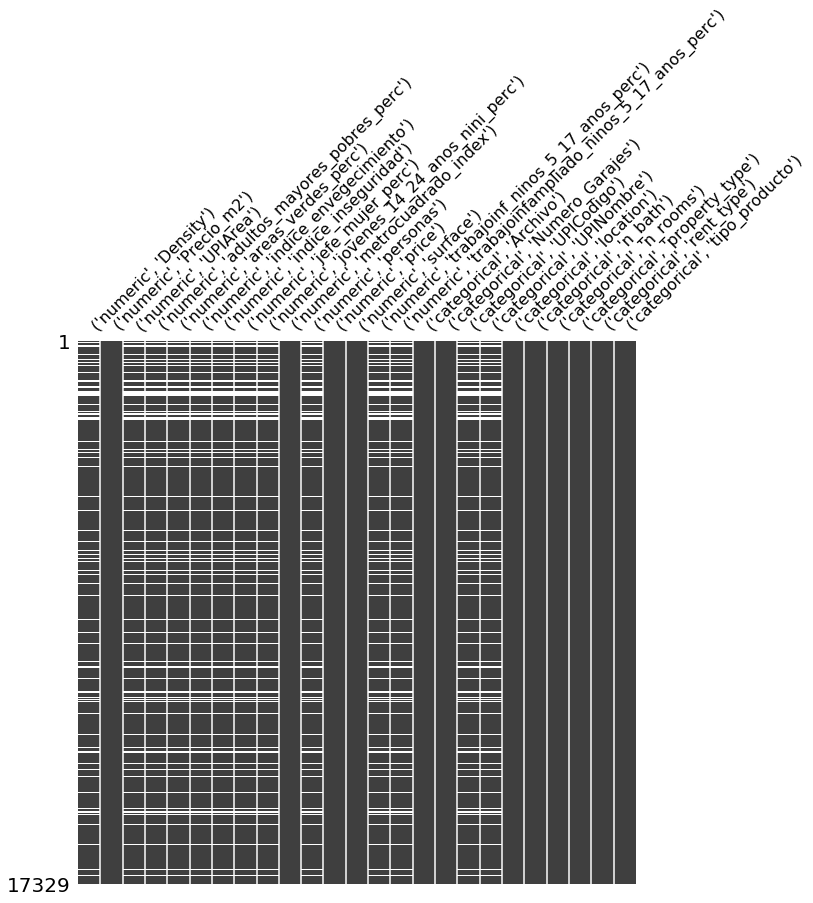

In [21]:
fig, ax = plt.subplots(figsize = [10, 10])
msno.matrix(df,ax = ax, sparkline=False)

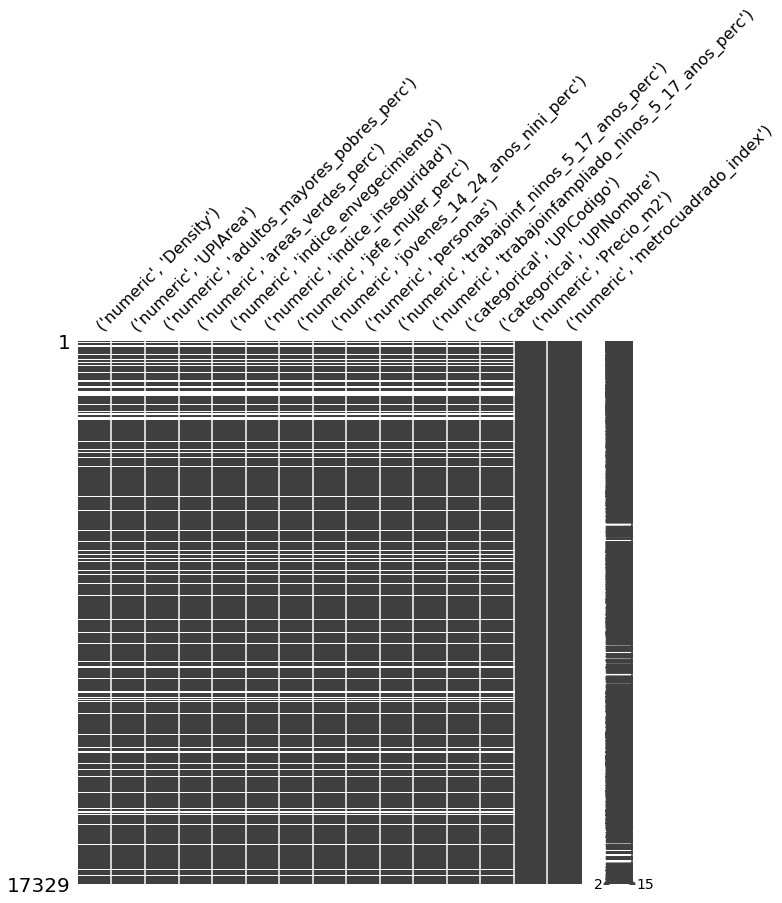

In [22]:
msno.matrix(df[df.isnull().sum().nlargest(15).index], sparkline=True, figsize=(10,10))

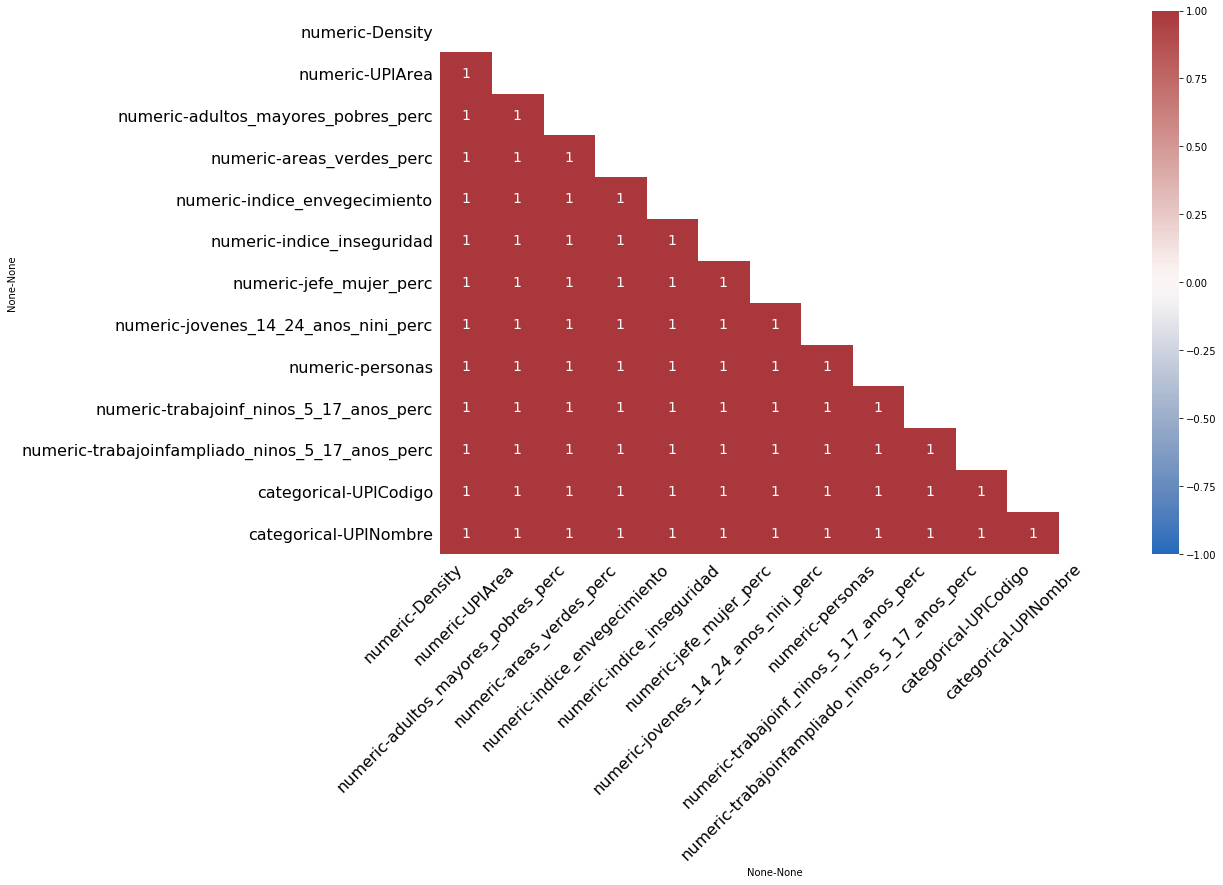

In [23]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(df, ax = ax, cmap='vlag')

In [ ]:
#Al final aparecian estas filas con NaN por las observaciones que no se les pudo asignar un codigo UPZ (1974)
#Falta implementar mecanismo de perdida de informacion

4. Recategoríce la variable código de UPZ de forma que quede distribuida entre 3 a 5 grupos, evalúe la significancia estadística de esta nueva agrupación en comparación a la variable de respuesta. Comente sus resultados e interprételos.\
__Hint:__ Puede probar con técnicas de clustering (como k-means) sobre una agrupación de UPZ y validar estadísticamente si las nuevas categorías afectan la variable de respuesta.

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [25]:
df.dropna(inplace=True) #Por ahora (mientras aun no se termine la parte 3)

In [26]:
'''Creo DataFrame auxiliar con hot encoding'''
aux = pd.get_dummies(df['categorical']['UPlCodigo'])
aux['Precio_m2']=df['numeric']['Precio_m2']
aux['UPlCodigo']=df['categorical']['UPlCodigo']

'''No considero outliers'''
q = aux['Precio_m2'].quantile(0.99)
aux=aux[aux['Precio_m2'] < q]

'''Normalizo datos'''
Xdata=pd.DataFrame(Normalizer().fit_transform(aux.iloc[:,:-2]), 
                   index=aux.iloc[:,:-2].index,
                   columns=aux.iloc[:,:-2].columns)

In [28]:
def upzcluster(n, aux=aux, data=Xdata):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
    labels=kmeans.labels_
    aux['label']=labels

    fig, ax = plt.subplots(2,1,figsize=(8,8))
    fig.suptitle('Analisis N° Cluster = '+str(n))

    sns.violinplot(x='label',y='Precio_m2',data=aux,kind='violin',ax=ax[0])

    sns.countplot(aux['label'], ax=ax[1])

    ax[0].set_xlabel('UPZ cluster')
    ax[1].set_xlabel('UPZ Cluster')

    ax[0].set_ylabel('Precio por m²')
    ax[0].set_title('Violin plot UPZ vs Price_m²')
    ax[1].set_title('Frecuencias UPZ Cluster')

    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)
    fig.show()
    print('N =', n)
    print('silhouette:',silhouette_score(data,labels))
    print('calinski harabasz:',calinski_harabasz_score(data, labels))
    print('='*80)
    clusters=[]
    for i in range(n):
        clusters.append(aux[aux.label==i].UPlCodigo.unique())
    
    return clusters

N = 3
silhouette: 0.37363836324026267
calinski harabasz: 3512.30048650658
N = 4
silhouette: 0.43971889938775244
calinski harabasz: 3219.0142837321855
N = 5
silhouette: 0.48507408737379876
calinski harabasz: 2963.629133937053


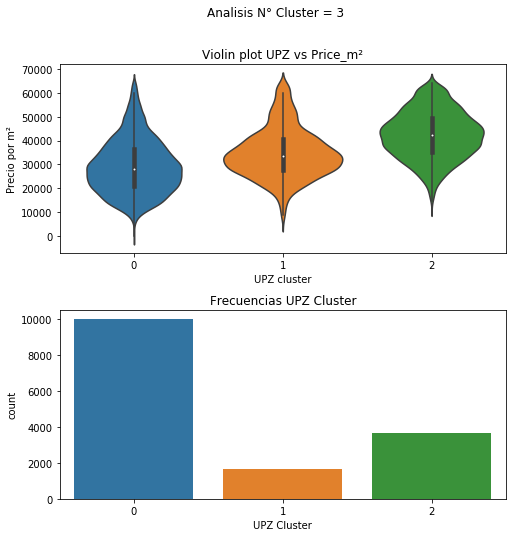

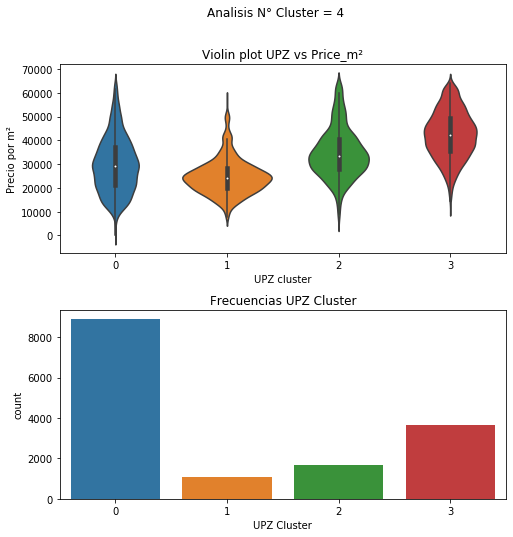

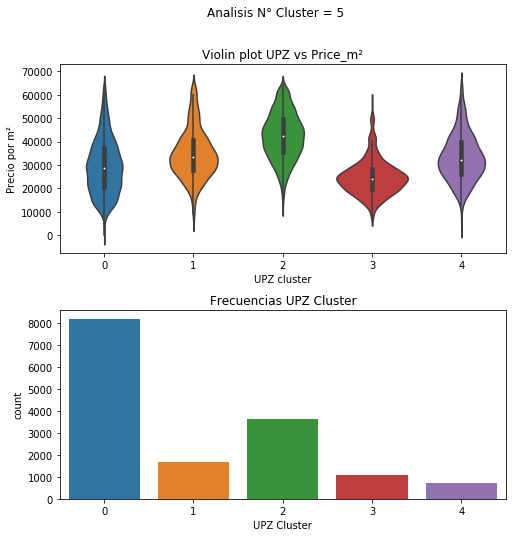

In [29]:
Groups=[]
for n in [3,4,5]:
    Groups.append(upzcluster(n))

In [ ]:
#El kmeans basicamente separa un codigo UPZ del resto de los demas con este encoding.

5. Cuantifique estadísticamente las relaciones entre una selección de al menos 10 variables de interés y la columna de respuesta, examine también las relaciones entre las variables de su selección. Utilice las herramientas de análisis estadístico que considere pertinentes, comente brevemente sus hallazgos.

6. En base a las herramientas del curso realice un análisis que permita detectar observaciones anómalas en la base de datos, justifique sus resultados, evalúe como se distribuyen los valores anómalos respecto a las variables UPZ y tipo de producto.

7. En función del análisis realizado a lo largo de esta pregunta, proponga una selección de variables que permita estimar la variable respuesta por medio de un modelo de regresión, discuta.

## P3. Regresión lineal bayesiana
Una vez analizado el conjunto de datos, se procede a modelar las relaciones por medio de alguna herramienta matemática. En este contexto y con las herramientas computacionales entregadas por el curso, se desarrolla un modelo de regresión lineal bayesiana, tratando el problema de modelación desde el punto vista teórico hasta su implementación e interpretación de resultados.

#### Implementación
1. Implemente la clase `RegresionBayesianaEmpirica` que herede de `BaseEstimator` y de `RegressorMixin` del módulo `sklearn.base` en la cual se implementa la heurística enunciada en la sección anterior para aproximar los hiperparámetros óptimos $\alpha$ y $\beta$. Esta clase sólo debe usar objetos de la librería `NumPy` y debe incluir al menos los siguientes métodos:
    * `__init__(self, alpha 0, beta 0, tol=1e-5, maxiter=200)`: sus argumentos son auto explicativos.
    * `get_posteriori(self, X, y, alpha, beta)`: que reciba la matriz de observaciones (`X`), el vector de etiquetas (`y`) y los hiperparámetros $\alpha$ y $\beta$. Este debe retornar los objetos necesarios para interactuar con los demás métodos.
    * `fit(self, X, y)`: que reciba la matriz de observaciones (`X`), el vector de etiquetas (`y`) e implemente el esquema de aproximación mencionado. Este método debe guardar como atributos del objeto los parámetros óptimos obtenidos, además de reportar en pantalla indicadores del proceso iterativo (incluya al menos el número de iteraciones).
    * `predict(self, X , return std=False)`: que reciba una matriz de observaciones (`X_`). Debe retornar la tupla (`y_` , `y_std`) con el vector de medias y el de desviaciones estándar (cuando `return std=True`) asociadas a las observaciones en `X`. Para esto, observe que el proceso de predicción corresponde a asignar la media posterior predictiva del modelo a nuevos puntos.
    
   Note que todo desarrollo sólo necesita de un modelo lineal en los parámetros $w$. Es decir, es posible reemplazar $X$ por una transformación (posiblemente no lineal) $\Phi(X)$, manteniendo la misma estructura distrubucional tanto en predicción como en obtención de hiperparámetros.

En las siguientes preguntas se construye un modelo de regresion en el cual debe incluir todas las variables disponibles en el conjunto de datos, reemplazando la variable de UPZ por la recategorizacion antes propuesta.

2. Construya un fujo de transformaciones sobre el conjunto datos. Por medio de la clase `Pipeline` debería:
    * Utilizar `StandardScaler` y `OneHotEncoder` donde corresponda.
    * Utilizar el objeto `PolynomialFeatures` para generar características polinomiales, en este apartado, se recomienda utilizar características de grado 3 sólo en las variables numéricas y luego concatenar con las codificaciones categóricas.
    * Generar una composición de transformaciones por medio de `ColumnTransformer`.

3. Expanda el `Pipeline` anterior agregando el modelo representado en la clase `RegresionBayesianaEmpirica`. Genere una separación de entrenamiento y test por medio de `train_test_split` del módulo `model_selection` donde el 20% de los datos sea de test. Entrene su modelo utilizando el método .fit como parámetros dentro del flujo creado por medio de Pipeline, evalúe su modelo por medio de la raíz del promedio de errores cuadráticos (_Root Mean Square Error - RMSE_. en inglés) en el conjunto de test, incluya el estadístico $R^2$.\
__Hint__: pruebe con valores para `alpha_0` y `beta_0` entre $10^{-10}$ y $10^{-5}$. Compruebe que dichos dichos hiperparametros son adecuados, al obtener un $R^2$ cercano a $0.7$.

4. Utilice su selección de variables, transfórmelas adaptando el esquema de preprocesamiento anterior, separe en conjuntos de entrenamiento y test manteniendo el 20% de proporción y evalúe los resultados del modelo `RegresionBayesianaEmpirica` incluyendo el estadístico $R^2$. Discuta.

5. Finalmente, compare los resultados de su selección de variables con los obtenidos por un pipeline donde el estimador sea uno de la clase `BayesianRidge` del módulo `sklearn.linear_model`. Discuta la diferencia de este módulo con respecto al desarrollado por ustedes.